# State Dependent Variational Quantum Cloning

In the following, we implement what is shown in section V. of the paper, namely a variational quantum circuit able to clone one of two states (referenced in the following as `A` and `B`)

In [396]:
import random
import numpy as np
import matplotlib.pyplot as plt

from numpy import pi as π

import perceval as pv
from scipy.optimize import minimize
from perceval.components import *

from collections import Counter

from submission.circuits import fullCircuit
import matplotlib.pyplot as plt
LAMBDA = 1

verbose = False

## Fidelity

Fidelity is calculated in the same as before

In [397]:
# Fraction of [1, 0, x, y] states
def getFidelityRho1(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[0] == 1 and state[1] == 0:
            validCounts += counts[state]
    if totCounts == 0: 
        return  1   
    return validCounts/totCounts


# Fraction of [x, y, 1, 0] states
def getFidelityRho2(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if state[2] == 1 and state[3] == 0:
            validCounts += counts[state]
    if totCounts == 0: 
        return 1
    return validCounts/totCounts

def getFidelities(counts):
    return (getFidelityRho1(counts), getFidelityRho2(counts))

def costFunctionAtPhi(counts):
    return (1 - getFidelityRho1(counts))**2 + (1 - getFidelityRho2(counts))**2 + (getFidelityRho1(counts)-getFidelityRho2(counts))**2

## Probabilities and cost function

In the following block we implement the functions required to calculate the new cost function ($\mathcal{C}_{SD}$).

To do this we first have to get the post-selection probability of the states A and B using the function `getProb`, after this we can calculate the value of the first two terms of the cost function (the ones containing the fidelity related to A and B) and finally we can calculate the complete cost function, that comprises all the terms:

$$\mathcal{C}_{SD} = (1-F_{1A})^{2}+(1-F_{2A})^{2}+(F_{1A}-F_{2A})^{2} + \\ (1-F_{1B})^{2}+(1-F_{2B})^{2}+(F_{1B}-F_{2B})^{2}+ \\
\lambda[(1 - P_A)^2 + (1 - P_B)^2 + (P_A - P_B)^2]$$

In [398]:
# Fraction of [1, 0, x, y] states
def getProb(counts):
    totCounts, validCounts = 0, 0

    for state in counts:
        totCounts += counts[state]
        if (state[0] == 1 and state[1] == 0) or (state[2]==1 and state[3]==0):
            validCounts += counts[state]

    return validCounts/totCounts



def costFunctionAtState(counts):
    '''get the cost function terms relative either to A or B
    IT DOES NOT INCLUED THE PROBABILITY TERM'''

    return (
            (1 - getFidelityRho1(counts))**2 + 
            (1 - getFidelityRho2(counts))**2 + 
            (getFidelityRho1(counts)-getFidelityRho2(counts))**2 
        )

def loss_function_SD(theta = [0] * 12, A_angles = [0,0], B_angles=[0,0]):
    cost = 0

    states_angles = [ A_angles, B_angles ]

    # holds the valid counts for A and B respectively
    valid_counts_A_B = [0,0]
    total_counts = [0,0]

    # Evaluate the first 2 terms of the cost function for A and B
    for state_idx, state in enumerate(states_angles):
        circuit = fullCircuit(theta_params=theta, prepTheta=state[0], prepPhi=state[1])
        p = pv.Processor("SLOS", circuit)
        p.with_input(pv.BasicState([0, 1, 0, 1]))

        sampler = pv.algorithm.Sampler(p)  
        sample_count = sampler.sample_count(1000)['results']

        valid_counts = {}
        for c in sample_count:
            if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
                valid_counts[c] = sample_count[c]
                valid_counts_A_B[state_idx] += sample_count[c]
            total_counts[state_idx] += sample_count[c]

        cost += costFunctionAtState(valid_counts)

    # Evaluate the final term of the cost function containing the probabilites
    PA = valid_counts_A_B[0]/total_counts[0]
    PB = valid_counts_A_B[1]/total_counts[1]
    if verbose:
        print(f"PA:{PA}\tPB:{PB}")
    cost += LAMBDA*((1-PA)**2 + (1-PB)**2 + (PA-PB)**2)
    return cost




In [399]:
def computeFidelity(x0, state_angles):

    circuit = fullCircuit(theta_params=x0, prepTheta=state_angles[0], prepPhi=state_angles[1])

    p = pv.Processor("SLOS", circuit)
    p.with_input(pv.BasicState([0, 1, 0, 1]))

    # The sampler holds 'probs', 'sample_count' and 'samples' calls. You can use the one that fits your needs!
    sampler = pv.algorithm.Sampler(p)  
    sample_count = sampler.sample_count(1000)['results']
    
    valid_counts = {}
    for c in sample_count:
        if c[0] != c[1] and c[2] != c[3]: #Since we introduce only 2 photons in the circuit it is enough
            valid_counts[c] = sample_count[c]

    fr1 = getFidelityRho1(valid_counts)
    fr2 = getFidelityRho2(valid_counts)

    return fr1, fr2

In [400]:
def optimCallback(intermediate_result):
    
    outLine = f'{intermediate_result.fun:0.3f}, '
    for x in intermediate_result.x:
        outLine += f'{x}, '
    outLine += '\n'

    if verbose:
        print(outLine)
    with open('ResultFile.csv', 'a+') as outFile:
        outFile.writelines([outLine])

## Minimization

The minimization procedure is similar to the one seen previously, in this case though, we have to provide the target states to be cloned

In [401]:
class ao():
    def __init__(self, x0):
        self.x = x0

def minimizeVal(swapMimimizers, x0 = None, maxIter = 100, target_states =([np.pi/2, np.pi/8], [np.pi/2, -np.pi/8])):
    res = ao((np.random.rand(1, 12)[0])*2*π) if x0 == None else ao(x0)

    # print(res.x)

    with open('ResultFile.csv', 'w') as outFile:
        outFile.writelines('Fun, p0, p1, p2, p3, p4, p5, p6, p7, p8, p9, p10, p11')

    for minimizerSwapIndex in range(swapMimimizers):
        res = minimize(loss_function_SD,
            res.x,
            args=target_states,
            method="Nelder-Mead",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback,
            options={'maxiter':maxIter}
        )
        optimCallback(res)


        res = minimize(loss_function_SD,
            res.x,
            args=target_states,
            method="powell",
            bounds=[(0, 2*π)]*12,
            callback=optimCallback
        )
        optimCallback(res)


    return res

### Recreating the paper's results

We now test our code using the same input states as the paper, these states are listed in `ts_list`.
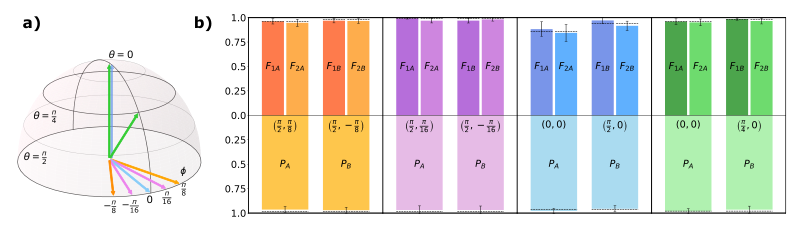


In [ ]:
ts_list = [
    ([np.pi/2, np.pi/8], [np.pi/2, -np.pi/8]), #orange
    ([np.pi/2, np.pi/16], [np.pi/2, -np.pi/16]), #purple
    ([0,0], [np.pi/2, 0]), #blue
    ([0,0], [np.pi/4, 0]), #green
]
res_string = ''''''
for target_states in ts_list:
    res = minimizeVal(2, target_states=target_states)
    res_string += (f"({target_states[0][0]}, {target_states[0][1]})\tfidelity A: {computeFidelity(res.x, target_states[0])}\n")
    res_string += (f"({target_states[1][0]}, {target_states[1][1]})\tfidelity B: {computeFidelity(res.x, target_states[1])}\n\n")

In [403]:
print(res_string)

(1.5707963267948966, 0.39269908169872414)	fidelity A: (0.960741548527808, 1.0)
(1.5707963267948966, -0.39269908169872414)	fidelity B: (0.9714889123548046, 1.0)

(1.5707963267948966, 0.19634954084936207)	fidelity A: (0.9787018255578094, 0.9837728194726166)
(1.5707963267948966, -0.19634954084936207)	fidelity B: (0.9949849548645938, 0.9749247743229689)

(0, 0)	fidelity A: (1.0, 1.0)
(1.5707963267948966, 0)	fidelity B: (0.9987908101571947, 0.9903264812575574)

(0, 0)	fidelity A: (1.0, 0.9377593360995851)
(0.7853981633974483, 0)	fidelity B: (1.0, 0.9770354906054279)




In [404]:
import csv

Min cost: 0.004 


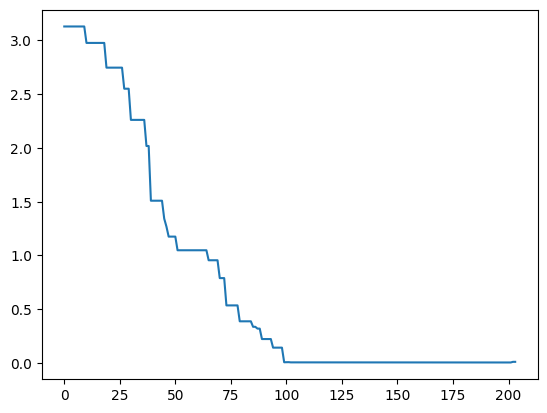

In [405]:
with open('ResultFile.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    next(spamreader)
    costs = []
    minCost = 10
    minConfig = []
    for row in spamreader:
        costs.append(float(row[0]))
        if costs[-1] < minCost:
            minCost = costs[-1]
            minConfig = [float(el) for el in row[1:13]]
        
plt.plot(costs)
print(f'Min cost: {minCost} ')